📌 What We'll Do

We will build two CNN models:

1️⃣ Forward-Only CNN (No Backpropagation)

- Uses random weights (not updated).
- Only performs forward propagation.
- No learning happens.

2️⃣ Trained CNN (With Backpropagation)

- Uses gradient descent to learn.
- Updates weights & improves performance.
- Learns from errors over multiple epochs.

🔍 Comparison:

- Accuracy difference
- Loss reduction
- Feature learning (visualizing feature maps)

#### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


### Load the MNIST Dataset

##### Data transformation: Convert images to tensors & normalize pixel values

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values (-1 to 1)
])

##### Load MNIST dataset (Handwritten Digits)

In [3]:

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_data = datasets.MNIST(root="./data", train=False, transform=transform, download=True)


100.0%
100.0%
100.0%
100.0%


##### Create Data Loaders

In [4]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [5]:
# Print dataset size
print(f"Training samples: {len(train_data)}, Test samples: {len(test_data)}")

Training samples: 60000, Test samples: 10000


### Define the CNN Architecture

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Conv layer 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Conv layer 2
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer (reduces size)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, 10)  # Fully connected layer 2 (10 classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling
        x = x.view(-1, 32 * 7 * 7)  # Flatten feature maps
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x


#### Forward-Only CNN (No Backpropagation)

In [7]:
def evaluate_forward_only(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient updates
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Forward-Only CNN Accuracy: {accuracy:.2f}%")
    return accuracy

##### Initialize CNN with random weights


In [8]:
cnn_forward_only = CNN()

##### Evaluate without training

In [9]:

forward_accuracy = evaluate_forward_only(cnn_forward_only, test_loader)

Forward-Only CNN Accuracy: 9.12%


### Train CNN with Backpropagation

In [10]:
# Initialize model
cnn_trained = CNN()
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(cnn_trained.parameters(), lr=0.001)  # Adam optimizer

In [11]:
# Training loop
epochs = 5
loss_history = []
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = cnn_trained(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.2036
Epoch 2/5, Loss: 0.0537
Epoch 3/5, Loss: 0.0380
Epoch 4/5, Loss: 0.0296
Epoch 5/5, Loss: 0.0229


In [12]:
# Evaluate trained model
trained_accuracy = evaluate_forward_only(cnn_trained, test_loader)

Forward-Only CNN Accuracy: 98.89%


#### Compare Accuracy & Loss

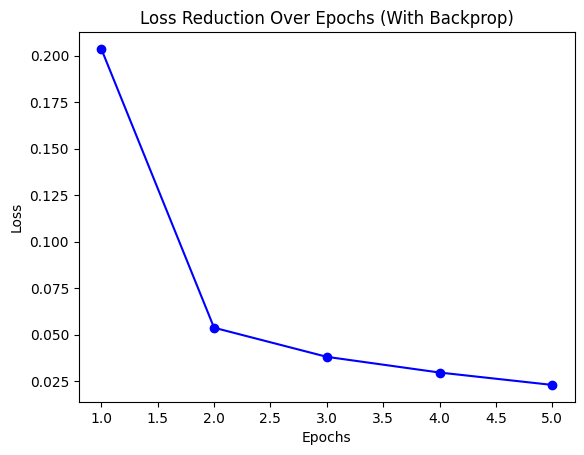

Forward-Only CNN Accuracy: 9.12%
Trained CNN Accuracy: 98.89%


In [13]:
# Plot loss reduction over epochs
plt.plot(range(1, epochs+1), loss_history, marker='o', linestyle='-', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Reduction Over Epochs (With Backprop)")
plt.show()

# Print accuracy comparison
print(f"Forward-Only CNN Accuracy: {forward_accuracy:.2f}%")
print(f"Trained CNN Accuracy: {trained_accuracy:.2f}%")

##### Visualize Feature Learning

In [14]:
def visualize_features(model, image):
    image = image.unsqueeze(0)  # Add batch dimension
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Conv1 Features
    with torch.no_grad():
        conv1_output = model.conv1(image).detach().numpy()[0]
    axes[0].imshow(conv1_output[0], cmap="gray")
    axes[0].set_title("Conv1 Features")

    # Conv2 Features
    with torch.no_grad():
        conv2_input = model.pool(F.relu(model.conv1(image)))
        conv2_output = model.conv2(conv2_input).detach().numpy()[0]
    axes[1].imshow(conv2_output[0], cmap="gray")
    axes[1].set_title("Conv2 Features")

    plt.show()



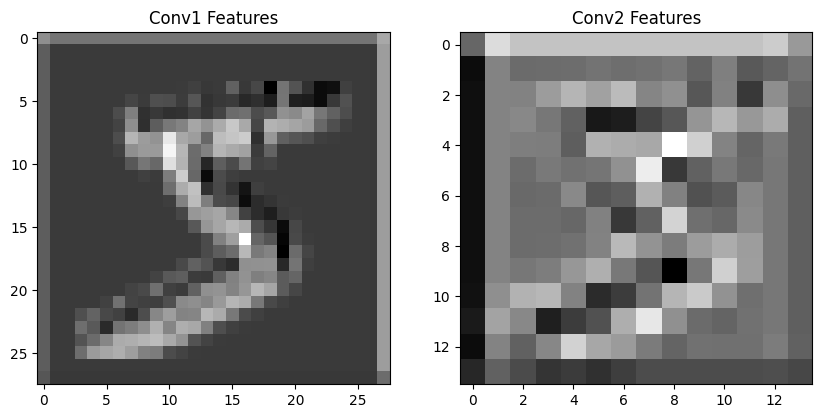

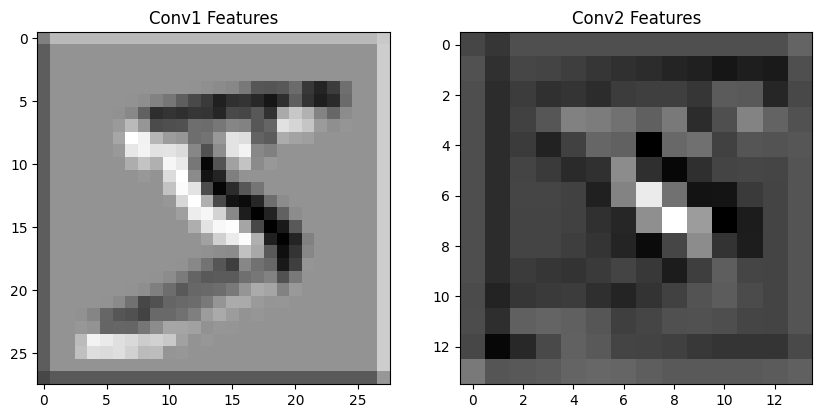

In [15]:
# Pick an image from dataset
sample_image, _ = train_data[0]
visualize_features(cnn_forward_only, sample_image)  # Before Training
visualize_features(cnn_trained, sample_image)  # After Training
